In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import io
import collections
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer('english')

In [3]:
from subprocess import check_output
#print(check_output(["ls", "./Input"]).decode("utf8"))

In [4]:
# input data
train_data = pd.read_csv('./Input/train.csv', encoding="ISO-8859-1")
test_data = pd.read_csv('./Input/test.csv', encoding = 'ISO-8859-1')
description = pd.read_csv('./Input/product_descriptions.csv',encoding="ISO-8859-1")
attribute = pd.read_csv('./Input/attributes.csv',encoding="ISO-8859-1")

,product_uid,product_description
0,100001,"Not only do angles make joints stronger, they ..."
1,100002,BEHR Premium Textured DECKOVER is an innovativ...
2,100003,Classic architecture meets contemporary design...
3,100004,The Grape Solar 265-Watt Polycrystalline PV So...
4,100005,Update your bathroom with the Delta Vero Singl...


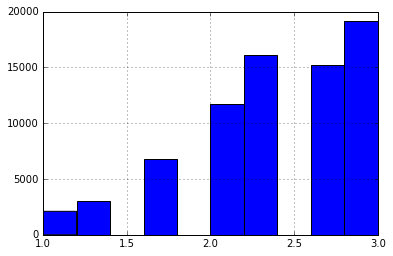

In [167]:
train_data.relevance.hist()
description.head()

In [168]:
# merge description
train = pd.merge(train_data, description, on='product_uid', how= 'left')
test = pd.merge(test_data, description, on='product_uid', how= 'left')

In [169]:
# check null for product_uid
train[train['product_uid'].isnull()==True]
test[test['product_uid'].isnull()==True]
print ('No null in product_uid.\n')

print(str(train.info()))
print ('\n')
print (str(test.info()))
print ('\n')
print (str(attribute.info()))

No null in product_uid.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74067 entries, 0 to 74066
Data columns (total 6 columns):
id                     74067 non-null int64
product_uid            74067 non-null int64
product_title          74067 non-null object
search_term            74067 non-null object
relevance              74067 non-null float64
product_description    74067 non-null object
dtypes: float64(1), int64(2), object(3)
memory usage: 4.0+ MB
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 166693 entries, 0 to 166692
Data columns (total 5 columns):
id                     166693 non-null int64
product_uid            166693 non-null int64
product_title          166693 non-null object
search_term            166693 non-null object
product_description    166693 non-null object
dtypes: int64(2), object(3)
memory usage: 7.6+ MB
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2044803 entries, 0 to 2044802
Data columns (total 3 columns):
product_uid    float64

In [170]:
#attribute[attribute['product_uid'].isnull()==True]

In [171]:
# drop nas, change datatype product_uid: float--int value:obj--str
attribute.dropna(how='all',inplace=True)
attribute['product_uid'] = attribute.product_uid.astype(int)
attribute["name"]= attribute.name.astype('U')
attribute["value"]= attribute.value.astype('U')
attribute.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2044648 entries, 0 to 2044802
Data columns (total 3 columns):
product_uid    int32
name           object
value          object
dtypes: int32(1), object(2)
memory usage: 54.6+ MB


In [172]:
# attrs is same for the same product_uid
def concate_attrs(attrs):
    names = attrs['name']
    values = attrs['value']
    pairs = []
    for n, v in zip(names, values):
        pairs.append(' '.join((n,v)))
    return ' '.join(pairs)

product_attrs = attribute.groupby('product_uid').apply(concate_attrs)
product_attrs = product_attrs.reset_index(name = 'pro_attrs')

In [173]:
product_attrs.head()

,product_uid,pro_attrs
0,100001,Bullet01 Versatile connector for various 90Â° ...
1,100002,"Application Method Brush,Roller,Spray Assemble..."
2,100003,Built-in flange Yes Bullet01 Slightly narrower...
3,100004,Amperage (amps) 8.56 Bullet01 Positive power t...
4,100005,Bath Faucet Type Combo Tub and Shower Built-in...


In [174]:
# check product_uid count
print (product_attrs.product_uid.unique().size)
print (train.product_uid.unique().size)
print (test.product_uid.unique().size)

86263
54667
97460


In [175]:
# merge the attributes df
df_all = pd.concat((train, test), axis=0, ignore_index=True)
df_all = pd.merge(df_all, product_attrs, how='left', on='product_uid')
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240760 entries, 0 to 240759
Data columns (total 7 columns):
id                     240760 non-null int64
product_description    240760 non-null object
product_title          240760 non-null object
product_uid            240760 non-null int64
relevance              74067 non-null float64
search_term            240760 non-null object
pro_attrs              194935 non-null object
dtypes: float64(1), int64(2), object(4)
memory usage: 14.7+ MB


In [176]:
df_all[df_all.pro_attrs.isnull()==True].size

320775

In [177]:
df_all['pro_attrs'] = df_all['pro_attrs'].fillna('No')

In [178]:
df_all.head()

,id,product_description,product_title,product_uid,relevance,search_term,pro_attrs
0,2,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie 12-Gauge Angle,100001,3.00,angle bracket,Bullet01 Versatile connector for various 90Â° ...
1,3,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie 12-Gauge Angle,100001,2.50,l bracket,Bullet01 Versatile connector for various 90Â° ...
2,9,BEHR Premium Textured DECKOVER is an innovativ...,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,100002,3.00,deck over,"Application Method Brush,Roller,Spray Assemble..."
3,16,Update your bathroom with the Delta Vero Singl...,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,100005,2.33,rain shower head,Bath Faucet Type Combo Tub and Shower Built-in...
4,17,Update your bathroom with the Delta Vero Singl...,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,100005,2.67,shower only faucet,Bath Faucet Type Combo Tub and Shower Built-in...


In [179]:
# get the brand information
print attribute.product_uid.unique().size
print attribute[attribute.name == 'MFG Brand Name'].groupby('product_uid').count()

brands = attribute[attribute.name == 'MFG Brand Name'][['product_uid','value']].rename(columns ={'value':'brand'})

# merge the brand infor

df_all = pd.merge(df_all, brands, on='product_uid', how='left')
df_all.brand.fillna('Unknown', inplace=True)

86263
             name  value
product_uid             
100001          1      1
100002          1      1
100003          1      1
100004          1      1
100005          1      1
100006          1      1
100007          1      1
100008          1      1
100009          1      1
100010          1      1
100011          1      1
100012          1      1
100013          1      1
100014          1      1
100015          1      1
100016          1      1
100017          1      1
100018          1      1
100019          1      1
100020          1      1
100021          1      1
100022          1      1
100023          1      1
100024          1      1
100025          1      1
100026          1      1
100027          1      1
100028          1      1
100029          1      1
100030          1      1
...           ...    ...
224396          1      1
224397          1      1
224398          1      1
224399          1      1
224400          1      1
224401          1      1
224402          1  

In [180]:
attribute[attribute.name.isnull()==True]
attribute.name.fillna(' ', inplace=True)

In [181]:
df_all.head()

,id,product_description,product_title,product_uid,relevance,search_term,pro_attrs,brand
0,2,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie 12-Gauge Angle,100001,3.00,angle bracket,Bullet01 Versatile connector for various 90Â° ...,Simpson Strong-Tie
1,3,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie 12-Gauge Angle,100001,2.50,l bracket,Bullet01 Versatile connector for various 90Â° ...,Simpson Strong-Tie
2,9,BEHR Premium Textured DECKOVER is an innovativ...,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,100002,3.00,deck over,"Application Method Brush,Roller,Spray Assemble...",BEHR Premium Textured DeckOver
3,16,Update your bathroom with the Delta Vero Singl...,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,100005,2.33,rain shower head,Bath Faucet Type Combo Tub and Shower Built-in...,Delta
4,17,Update your bathroom with the Delta Vero Singl...,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,100005,2.67,shower only faucet,Bath Faucet Type Combo Tub and Shower Built-in...,Delta


In [182]:
# get material infor
#print attribute.product_uid.unique().size
#print  attribute[(attribute.name.str.lower()).str.contains("material")]

materials = attribute[(attribute.name.str.lower()).str.contains("material")][['product_uid','value']].rename(columns ={'value':'material'})

# concate material infor for the same procutc_uid
def concate_material(attrs):
    materials = attrs['material']
    adds = []
    for m in zip(materials):
        adds.append(' '.join(m))
    return ' '.join(adds)

prod_material = materials.groupby('product_uid').apply(concate_material)
prod_material = prod_material.reset_index(name = 'material')
prod_material.tail()

# merge the material infor

df_all = pd.merge(df_all, prod_material, on='product_uid', how='left')

df_all.material.fillna('Unknown', inplace=True)

,id,product_description,product_title,product_uid,relevance,search_term,pro_attrs,brand,material
0,2,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie 12-Gauge Angle,100001,3.00,angle bracket,Bullet01 Versatile connector for various 90Â° ...,Simpson Strong-Tie,Galvanized Steel
1,3,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie 12-Gauge Angle,100001,2.50,l bracket,Bullet01 Versatile connector for various 90Â° ...,Simpson Strong-Tie,Galvanized Steel
2,9,BEHR Premium Textured DECKOVER is an innovativ...,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,100002,3.00,deck over,"Application Method Brush,Roller,Spray Assemble...",BEHR Premium Textured DeckOver,NaN
3,16,Update your bathroom with the Delta Vero Singl...,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,100005,2.33,rain shower head,Bath Faucet Type Combo Tub and Shower Built-in...,Delta,NaN
4,17,Update your bathroom with the Delta Vero Singl...,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,100005,2.67,shower only faucet,Bath Faucet Type Combo Tub and Shower Built-in...,Delta,NaN


In [187]:
# check what kind of words in name
words = collections.Counter()
for name in attribute.name:
    words.update(str(name).lower().split())
for word in words.most_common(200):
    print word
    

('(in.)', 354016)
('product', 302840)
('type', 176295)
('width', 111152)
('height', 97211)
('name', 90701)
('depth', 87765)
('brand', 87496)
('mfg', 86250)
('bullet02', 86248)
('bullet03', 86226)
('bullet04', 86174)
('bullet01', 85940)
('family', 66036)
('color', 65690)
('material', 62503)
('bullet05', 60529)
('assembled', 55369)
('(lb.)', 51933)
('weight', 51431)
('length', 46818)
('bullet06', 44901)
('included', 44157)
('of', 42606)
('number', 42063)
('color/finish', 40989)
('size', 35021)
('bullet07', 34349)
('features', 31579)
('and', 26878)
('bullet08', 26645)
('certifications', 24583)
('listings', 24583)
('finish', 23783)
('door', 23120)
('bullet09', 20567)
('maximum', 20287)
('style', 20069)
('bulb', 19552)
('light', 17218)
('resistant', 16265)
('thickness', 15988)
('to', 15379)
('hardware', 15354)
('bullet10', 14763)
('required', 14303)
('diameter', 14008)
('faucet', 13104)
('indoor/outdoor', 12959)
('capacity', 12392)
('top', 11957)
('bullet11', 11784)
('tool', 11744)
('shape'

In [190]:
def summarize(name,values):
    values.fillna('',inplace=True)
    counts = collections.Counter()
    for value in values:
        counts[value.lower()] += 1
    total = sum(counts.values())

    print("{} counts ({:,} values)".format(name, total))
    for word, count in counts.most_common(20):
        print("{}: {:.1f}% ({:,})".format(word, 100. * count / total, count))

for attribute_name in ["Color Family", "Color/Finish", "Material", "MFG Brand Name", "Indoor/Outdoor", "Commercial / Residential"]:
    summarize("\n" + attribute_name, attribute[attribute.name == attribute_name].value)



Color Family counts (41,508 values)
white: 15.8% (6,546)
black: 7.5% (3,115)
brown: 5.6% (2,339)
gray: 4.6% (1,892)
whites: 4.4% (1,829)
chrome: 3.9% (1,616)
browns / tans: 3.5% (1,463)
red: 3.0% (1,239)
blacks: 3.0% (1,237)
bronze: 2.8% (1,151)
metallics: 2.6% (1,078)
nickel: 2.5% (1,028)
beige: 2.3% (950)
grays: 2.3% (939)
blue: 2.1% (891)
silver: 2.1% (871)
stainless steel: 2.0% (824)
beige / cream: 1.9% (788)
greens: 1.7% (713)
multi: 1.6% (669)

Color/Finish counts (28,564 values)
white: 14.4% (4,115)
black: 5.7% (1,628)
stainless steel: 3.7% (1,065)
chrome: 3.5% (995)
gray: 1.7% (482)
brushed nickel: 1.7% (473)
oil rubbed bronze: 1.3% (375)
polished chrome: 1.3% (370)
brown: 1.1% (328)
primed white: 1.1% (324)
clear: 1.1% (316)
red: 0.9% (251)
blue: 0.8% (218)
satin nickel: 0.7% (213)
beige: 0.7% (210)
silver: 0.7% (198)
biscuit: 0.7% (196)
almond: 0.7% (187)
stainless: 0.6% (180)
bronze: 0.6% (176)

Material counts (31,500 values)
steel: 13.2% (4,151)
metal: 9.6% (3,029)
plasti

C:\Users\mingh_000\Anaconda2\lib\site-packages\pandas\core\generic.py:2862: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [193]:
# stem the words




,id,product_description,product_title,product_uid,relevance,search_term,pro_attrs,brand,material
0,2,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie 12-Gauge Angle,100001,3.00,angle bracket,Bullet01 Versatile connector for various 90Â° ...,Simpson Strong-Tie,Galvanized Steel
1,3,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie 12-Gauge Angle,100001,2.50,l bracket,Bullet01 Versatile connector for various 90Â° ...,Simpson Strong-Tie,Galvanized Steel
2,9,BEHR Premium Textured DECKOVER is an innovativ...,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,100002,3.00,deck over,"Application Method Brush,Roller,Spray Assemble...",BEHR Premium Textured DeckOver,Unknown
3,16,Update your bathroom with the Delta Vero Singl...,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,100005,2.33,rain shower head,Bath Faucet Type Combo Tub and Shower Built-in...,Delta,Unknown
4,17,Update your bathroom with the Delta Vero Singl...,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,100005,2.67,shower only faucet,Bath Faucet Type Combo Tub and Shower Built-in...,Delta,Unknown


,id,product_uid,product_title,search_term,relevance,product_description
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00,"Not only do angles make joints stronger, they ..."
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50,"Not only do angles make joints stronger, they ..."
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00,BEHR Premium Textured DECKOVER is an innovativ...
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33,Update your bathroom with the Delta Vero Singl...
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67,Update your bathroom with the Delta Vero Singl...
